# Import Libraries

In [1]:
#https://github.com/tanishqgautam/Drone-Image-Semantic-Segmentation/blob/main/semantic-segmentation-pytorch.ipynb
#https://towardsdatascience.com/the-essential-library-to-build-segmentation-models-6e17e81338e

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install segmentation-models-pytorch #installam bibliotecile pe colab
!pip install -U albumentations

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install segmentation-models-pytorch
!pip install torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=e61a3160173542fa998bacc31d4d4ae1d10dbb2a8f7bfdd8c4e5cf2a75983509
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9b

In [3]:
os.chdir('/content/gdrive/MyDrive/date_dizertatie')
base_path = '/content/gdrive/MyDrive/date_dizertatie'

# Preprocessing

In [4]:
# IMAGE_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
# MASK_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

IMAGE_PATH = base_path + '/graz_drone_dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = base_path + '/graz_drone_dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [5]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [6]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


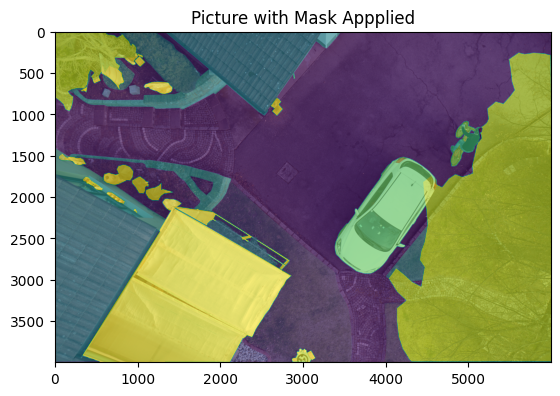

In [7]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

In [8]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

**bold text**# Model\

---



In [10]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context #bug ssl

unet_mobile = smp.FPN('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5)
unet_resnet = smp.FPN('resnet34', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5)
unet_efficient = smp.FPN('efficientnet-b0', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5)
unet_densenet = smp.FPN('densenet121', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 34.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 70.3MB/s]
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 43.6MB/s]
Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/hub/checkpoints/densenet121-fbdb23505.pth
100%|██████████| 30.9M/30.9M [01:31<00:00, 354kB/s]


In [11]:
#model

# Training

*   List item
*   List item



In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [13]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

#unet_mobile
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(unet_mobile.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_mobile = fit(epoch, unet_mobile, train_loader, val_loader, criterion, optimizer, sched)
torch.save(unet_resnet, 'fpn-mobilenet.pt')
column = list(history_mobile.keys())[:-1]
val = list(history_mobile.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('fpn_mobilenet_cross_entropy.csv')



  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.995 
Epoch:1/15.. Train Loss: 2.265.. Val Loss: 0.995.. Train mIoU:0.100.. Val mIoU: 0.218.. Train Acc:0.460.. Val Acc:0.716.. Time: 17.75m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.995 >> 0.893 
Epoch:2/15.. Train Loss: 1.278.. Val Loss: 0.893.. Train mIoU:0.213.. Val mIoU: 0.269.. Train Acc:0.642.. Val Acc:0.725.. Time: 4.37m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.893 >> 0.788 
Epoch:3/15.. Train Loss: 1.118.. Val Loss: 0.788.. Train mIoU:0.241.. Val mIoU: 0.284.. Train Acc:0.678.. Val Acc:0.760.. Time: 4.41m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/15.. Train Loss: 0.992.. Val Loss: 0.822.. Train mIoU:0.270.. Val mIoU: 0.299.. Train Acc:0.707.. Val Acc:0.740.. Time: 4.31m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.822 >> 0.742 
saving model...
Epoch:5/15.. Train Loss: 0.907.. Val Loss: 0.742.. Train mIoU:0.297.. Val mIoU: 0.306.. Train Acc:0.735.. Val Acc:0.766.. Time: 4.41m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.742 >> 0.595 
Epoch:6/15.. Train Loss: 0.853.. Val Loss: 0.595.. Train mIoU:0.315.. Val mIoU: 0.371.. Train Acc:0.744.. Val Acc:0.820.. Time: 4.35m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.595 >> 0.520 
Epoch:7/15.. Train Loss: 0.788.. Val Loss: 0.520.. Train mIoU:0.332.. Val mIoU: 0.418.. Train Acc:0.760.. Val Acc:0.841.. Time: 4.38m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.520 >> 0.460 
Epoch:8/15.. Train Loss: 0.594.. Val Loss: 0.460.. Train mIoU:0.393.. Val mIoU: 0.444.. Train Acc:0.817.. Val Acc:0.859.. Time: 4.31m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/15.. Train Loss: 0.600.. Val Loss: 0.490.. Train mIoU:0.404.. Val mIoU: 0.428.. Train Acc:0.816.. Val Acc:0.851.. Time: 4.41m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.490 >> 0.419 
Epoch:10/15.. Train Loss: 0.505.. Val Loss: 0.419.. Train mIoU:0.436.. Val mIoU: 0.459.. Train Acc:0.842.. Val Acc:0.870.. Time: 4.45m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.419 >> 0.397 
saving model...
Epoch:11/15.. Train Loss: 0.477.. Val Loss: 0.397.. Train mIoU:0.454.. Val mIoU: 0.483.. Train Acc:0.851.. Val Acc:0.876.. Time: 4.44m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.397 >> 0.385 
Epoch:12/15.. Train Loss: 0.446.. Val Loss: 0.385.. Train mIoU:0.462.. Val mIoU: 0.481.. Train Acc:0.860.. Val Acc:0.879.. Time: 4.44m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.385 >> 0.372 
Epoch:13/15.. Train Loss: 0.414.. Val Loss: 0.372.. Train mIoU:0.483.. Val mIoU: 0.492.. Train Acc:0.869.. Val Acc:0.883.. Time: 4.31m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.372 >> 0.370 
Epoch:14/15.. Train Loss: 0.406.. Val Loss: 0.370.. Train mIoU:0.489.. Val mIoU: 0.504.. Train Acc:0.871.. Val Acc:0.884.. Time: 4.15m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.370 >> 0.368 
Epoch:15/15.. Train Loss: 0.393.. Val Loss: 0.368.. Train mIoU:0.492.. Val mIoU: 0.496.. Train Acc:0.875.. Val Acc:0.885.. Time: 4.18m
Total time: 78.67 m


In [16]:
#unet_resnet
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(unet_resnet.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_resnet = fit(epoch, unet_resnet, train_loader, val_loader, criterion, optimizer, sched)
torch.save(unet_resnet, 'fpn-resnet.pt')
column = list(history_resnet.keys())[:-1]
val = list(history_resnet.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('fpn_resnet_cross_entropy.csv')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.987 
Epoch:1/15.. Train Loss: 2.112.. Val Loss: 0.987.. Train mIoU:0.114.. Val mIoU: 0.208.. Train Acc:0.492.. Val Acc:0.716.. Time: 4.18m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:2/15.. Train Loss: 1.440.. Val Loss: 1.633.. Train mIoU:0.198.. Val mIoU: 0.201.. Train Acc:0.617.. Val Acc:0.594.. Time: 4.16m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:3/15.. Train Loss: 1.486.. Val Loss: 1.821.. Train mIoU:0.182.. Val mIoU: 0.103.. Train Acc:0.594.. Val Acc:0.473.. Time: 4.16m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.821 >> 0.993 
Epoch:4/15.. Train Loss: 1.362.. Val Loss: 0.993.. Train mIoU:0.187.. Val mIoU: 0.245.. Train Acc:0.613.. Val Acc:0.697.. Time: 4.22m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.993 >> 0.739 
Epoch:5/15.. Train Loss: 1.107.. Val Loss: 0.739.. Train mIoU:0.229.. Val mIoU: 0.296.. Train Acc:0.674.. Val Acc:0.772.. Time: 4.14m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:6/15.. Train Loss: 1.024.. Val Loss: 0.748.. Train mIoU:0.260.. Val mIoU: 0.281.. Train Acc:0.695.. Val Acc:0.776.. Time: 4.09m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:7/15.. Train Loss: 0.967.. Val Loss: 0.952.. Train mIoU:0.284.. Val mIoU: 0.257.. Train Acc:0.717.. Val Acc:0.703.. Time: 4.07m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.952 >> 0.609 
saving model...
Epoch:8/15.. Train Loss: 0.828.. Val Loss: 0.609.. Train mIoU:0.311.. Val mIoU: 0.376.. Train Acc:0.755.. Val Acc:0.810.. Time: 4.07m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:9/15.. Train Loss: 0.711.. Val Loss: 0.617.. Train mIoU:0.349.. Val mIoU: 0.351.. Train Acc:0.786.. Val Acc:0.811.. Time: 4.10m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.617 >> 0.541 
Epoch:10/15.. Train Loss: 0.663.. Val Loss: 0.541.. Train mIoU:0.374.. Val mIoU: 0.382.. Train Acc:0.797.. Val Acc:0.832.. Time: 4.03m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.541 >> 0.451 
Epoch:11/15.. Train Loss: 0.541.. Val Loss: 0.451.. Train mIoU:0.404.. Val mIoU: 0.433.. Train Acc:0.832.. Val Acc:0.860.. Time: 4.05m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.451 >> 0.444 
Epoch:12/15.. Train Loss: 0.502.. Val Loss: 0.444.. Train mIoU:0.429.. Val mIoU: 0.443.. Train Acc:0.844.. Val Acc:0.864.. Time: 4.21m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.444 >> 0.424 
Epoch:13/15.. Train Loss: 0.467.. Val Loss: 0.424.. Train mIoU:0.446.. Val mIoU: 0.472.. Train Acc:0.854.. Val Acc:0.869.. Time: 4.14m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.424 >> 0.409 
saving model...
Epoch:14/15.. Train Loss: 0.441.. Val Loss: 0.409.. Train mIoU:0.458.. Val mIoU: 0.469.. Train Acc:0.860.. Val Acc:0.873.. Time: 4.04m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:15/15.. Train Loss: 0.437.. Val Loss: 0.409.. Train mIoU:0.462.. Val mIoU: 0.459.. Train Acc:0.862.. Val Acc:0.873.. Time: 4.06m
Total time: 61.72 m


In [17]:
#unet_efficient
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(unet_efficient.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_efficient = fit(epoch, unet_efficient, train_loader, val_loader, criterion, optimizer, sched)
torch.save(unet_efficient, 'fpn-efficient.pt')
column = list(history_efficient.keys())[:-1]
val = list(history_efficient.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('fpn_efficient_cross_entropy.csv')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.134 
Epoch:1/15.. Train Loss: 2.501.. Val Loss: 1.134.. Train mIoU:0.092.. Val mIoU: 0.190.. Train Acc:0.454.. Val Acc:0.686.. Time: 4.08m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.134 >> 0.719 
Epoch:2/15.. Train Loss: 1.294.. Val Loss: 0.719.. Train mIoU:0.211.. Val mIoU: 0.333.. Train Acc:0.642.. Val Acc:0.786.. Time: 4.07m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.719 >> 0.633 
Epoch:3/15.. Train Loss: 1.010.. Val Loss: 0.633.. Train mIoU:0.283.. Val mIoU: 0.353.. Train Acc:0.712.. Val Acc:0.813.. Time: 4.08m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/15.. Train Loss: 0.871.. Val Loss: 0.638.. Train mIoU:0.321.. Val mIoU: 0.357.. Train Acc:0.741.. Val Acc:0.820.. Time: 4.01m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.638 >> 0.534 
saving model...
Epoch:5/15.. Train Loss: 0.746.. Val Loss: 0.534.. Train mIoU:0.349.. Val mIoU: 0.410.. Train Acc:0.776.. Val Acc:0.837.. Time: 4.02m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/15.. Train Loss: 0.631.. Val Loss: 0.614.. Train mIoU:0.389.. Val mIoU: 0.393.. Train Acc:0.809.. Val Acc:0.805.. Time: 4.04m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.614 >> 0.607 
Epoch:7/15.. Train Loss: 0.619.. Val Loss: 0.607.. Train mIoU:0.409.. Val mIoU: 0.399.. Train Acc:0.810.. Val Acc:0.830.. Time: 4.05m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.607 >> 0.430 
Epoch:8/15.. Train Loss: 0.577.. Val Loss: 0.430.. Train mIoU:0.424.. Val mIoU: 0.461.. Train Acc:0.825.. Val Acc:0.870.. Time: 4.16m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.430 >> 0.391 
Epoch:9/15.. Train Loss: 0.466.. Val Loss: 0.391.. Train mIoU:0.456.. Val mIoU: 0.489.. Train Acc:0.856.. Val Acc:0.879.. Time: 4.09m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.391 >> 0.390 
Epoch:10/15.. Train Loss: 0.442.. Val Loss: 0.390.. Train mIoU:0.472.. Val mIoU: 0.497.. Train Acc:0.863.. Val Acc:0.881.. Time: 4.09m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.390 >> 0.350 
saving model...
Epoch:11/15.. Train Loss: 0.452.. Val Loss: 0.350.. Train mIoU:0.484.. Val mIoU: 0.524.. Train Acc:0.861.. Val Acc:0.891.. Time: 4.06m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.350 >> 0.340 
Epoch:12/15.. Train Loss: 0.380.. Val Loss: 0.340.. Train mIoU:0.502.. Val mIoU: 0.519.. Train Acc:0.880.. Val Acc:0.894.. Time: 4.00m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:13/15.. Train Loss: 0.369.. Val Loss: 0.343.. Train mIoU:0.510.. Val mIoU: 0.509.. Train Acc:0.884.. Val Acc:0.894.. Time: 4.01m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.343 >> 0.331 
Epoch:14/15.. Train Loss: 0.357.. Val Loss: 0.331.. Train mIoU:0.519.. Val mIoU: 0.529.. Train Acc:0.887.. Val Acc:0.897.. Time: 3.98m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:15/15.. Train Loss: 0.337.. Val Loss: 0.332.. Train mIoU:0.530.. Val mIoU: 0.513.. Train Acc:0.892.. Val Acc:0.897.. Time: 3.98m
Total time: 60.72 m


In [18]:
#unet_densenet
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(unet_densenet.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_densenet = fit(epoch, unet_densenet, train_loader, val_loader, criterion, optimizer, sched)
torch.save(unet_efficient, 'fpn-densenet.pt')
column = list(history_densenet.keys())[:-1]
val = list(history_densenet.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('fpn_densenet_cross_entropy.csv')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.024 
Epoch:1/15.. Train Loss: 2.516.. Val Loss: 1.024.. Train mIoU:0.102.. Val mIoU: 0.219.. Train Acc:0.459.. Val Acc:0.724.. Time: 4.08m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.024 >> 0.976 
Epoch:2/15.. Train Loss: 1.233.. Val Loss: 0.976.. Train mIoU:0.215.. Val mIoU: 0.272.. Train Acc:0.660.. Val Acc:0.719.. Time: 4.12m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 1.106.. Val Loss: 1.133.. Train mIoU:0.246.. Val mIoU: 0.189.. Train Acc:0.691.. Val Acc:0.641.. Time: 4.22m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.133 >> 0.936 
Epoch:4/15.. Train Loss: 1.139.. Val Loss: 0.936.. Train mIoU:0.235.. Val mIoU: 0.255.. Train Acc:0.671.. Val Acc:0.736.. Time: 4.11m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.936 >> 0.742 
saving model...
Epoch:5/15.. Train Loss: 1.117.. Val Loss: 0.742.. Train mIoU:0.251.. Val mIoU: 0.316.. Train Acc:0.673.. Val Acc:0.784.. Time: 4.07m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.742 >> 0.661 
Epoch:6/15.. Train Loss: 0.854.. Val Loss: 0.661.. Train mIoU:0.299.. Val mIoU: 0.332.. Train Acc:0.740.. Val Acc:0.799.. Time: 4.02m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:7/15.. Train Loss: 0.775.. Val Loss: 0.836.. Train mIoU:0.338.. Val mIoU: 0.287.. Train Acc:0.770.. Val Acc:0.758.. Time: 4.07m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.836 >> 0.562 
Epoch:8/15.. Train Loss: 0.680.. Val Loss: 0.562.. Train mIoU:0.359.. Val mIoU: 0.406.. Train Acc:0.793.. Val Acc:0.839.. Time: 4.04m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.562 >> 0.470 
Epoch:9/15.. Train Loss: 0.579.. Val Loss: 0.470.. Train mIoU:0.401.. Val mIoU: 0.450.. Train Acc:0.821.. Val Acc:0.856.. Time: 4.08m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.470 >> 0.430 
Epoch:10/15.. Train Loss: 0.511.. Val Loss: 0.430.. Train mIoU:0.429.. Val mIoU: 0.454.. Train Acc:0.842.. Val Acc:0.868.. Time: 4.09m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.430 >> 0.387 
saving model...
Epoch:11/15.. Train Loss: 0.455.. Val Loss: 0.387.. Train mIoU:0.446.. Val mIoU: 0.484.. Train Acc:0.856.. Val Acc:0.879.. Time: 4.05m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:12/15.. Train Loss: 0.450.. Val Loss: 0.409.. Train mIoU:0.469.. Val mIoU: 0.460.. Train Acc:0.858.. Val Acc:0.875.. Time: 4.08m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.409 >> 0.373 
Epoch:13/15.. Train Loss: 0.434.. Val Loss: 0.373.. Train mIoU:0.469.. Val mIoU: 0.486.. Train Acc:0.863.. Val Acc:0.882.. Time: 4.05m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.373 >> 0.368 
Epoch:14/15.. Train Loss: 0.399.. Val Loss: 0.368.. Train mIoU:0.481.. Val mIoU: 0.492.. Train Acc:0.874.. Val Acc:0.885.. Time: 4.07m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:15/15.. Train Loss: 0.374.. Val Loss: 0.373.. Train mIoU:0.495.. Val mIoU: 0.502.. Train Acc:0.882.. Val Acc:0.884.. Time: 4.04m
Total time: 61.20 m


In [19]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

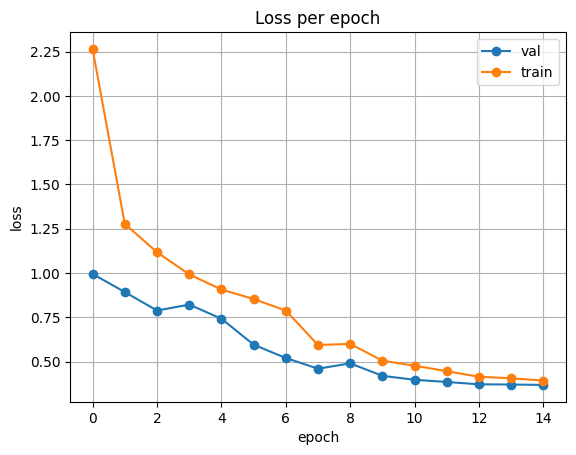

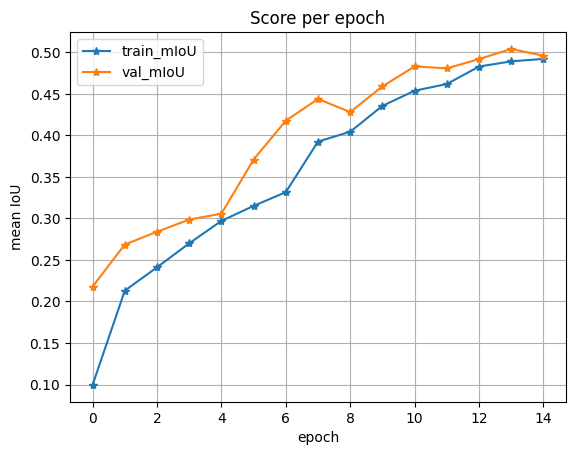

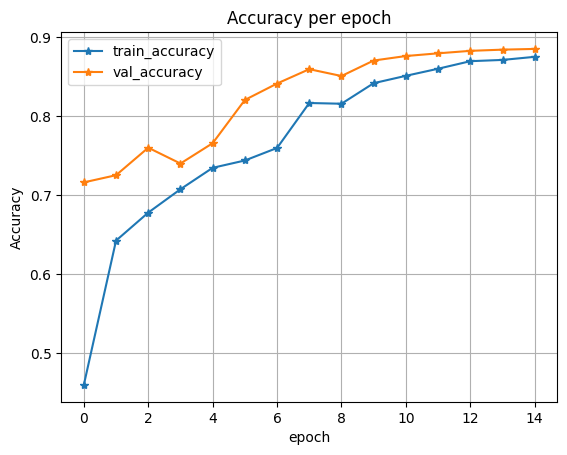

In [20]:
plot_loss(history_mobile)
plot_score(history_mobile)
plot_acc(history_mobile)

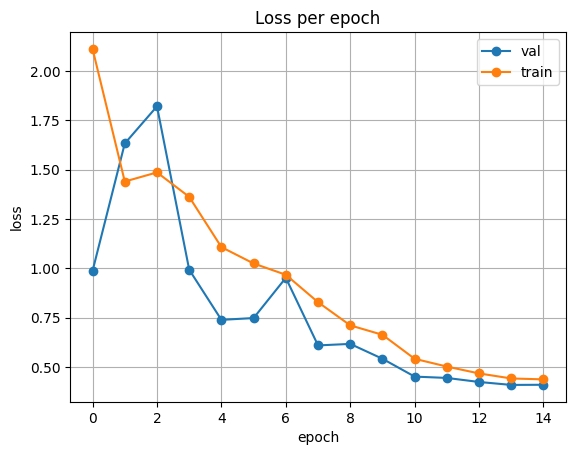

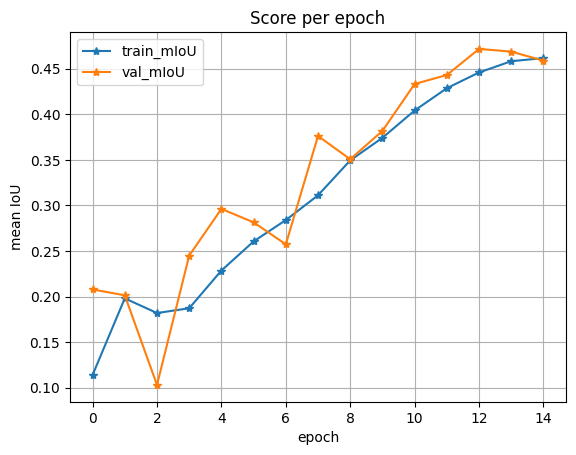

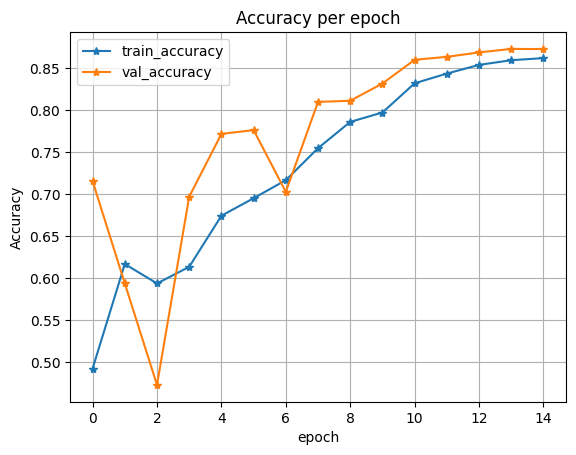

In [21]:
plot_loss(history_resnet)
plot_score(history_resnet)
plot_acc(history_resnet)

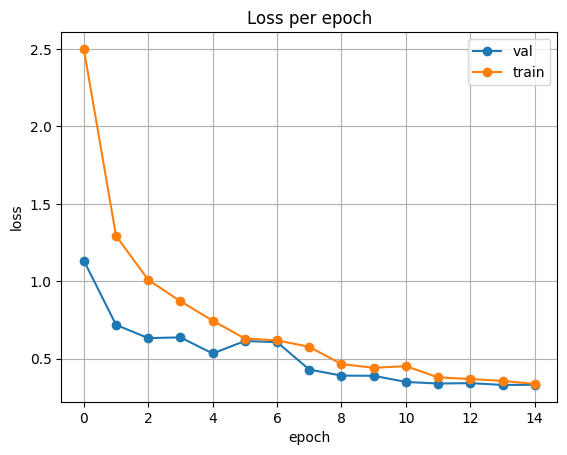

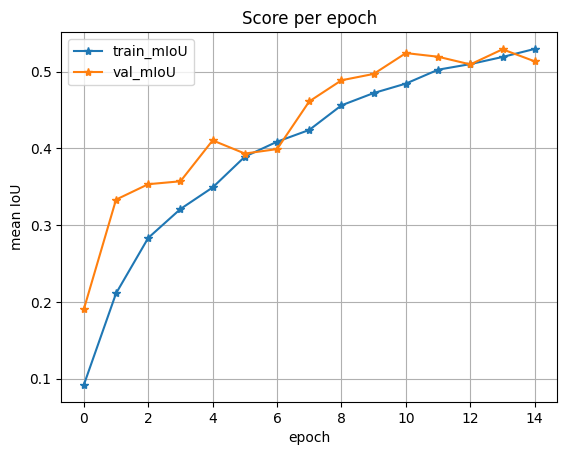

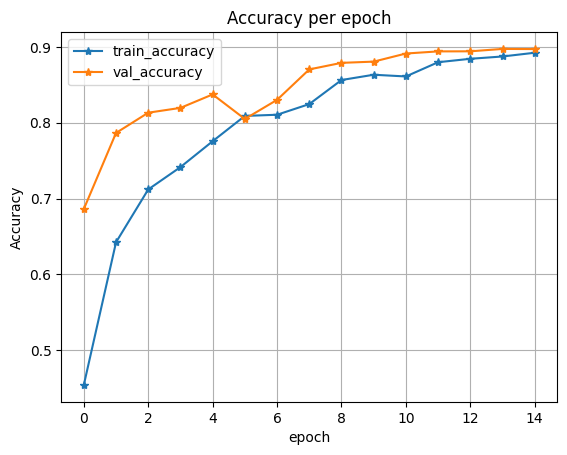

In [22]:
plot_loss(history_efficient)
plot_score(history_efficient)
plot_acc(history_efficient)

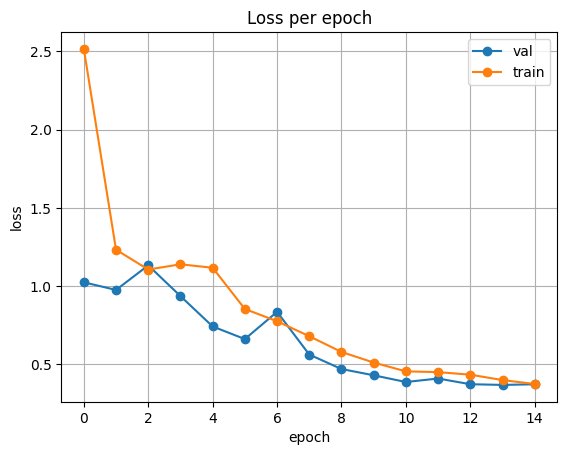

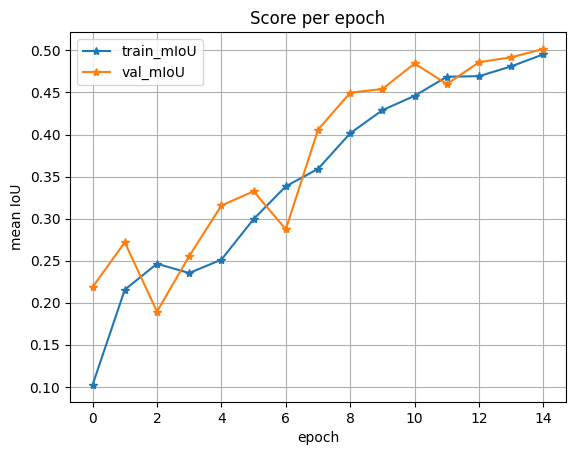

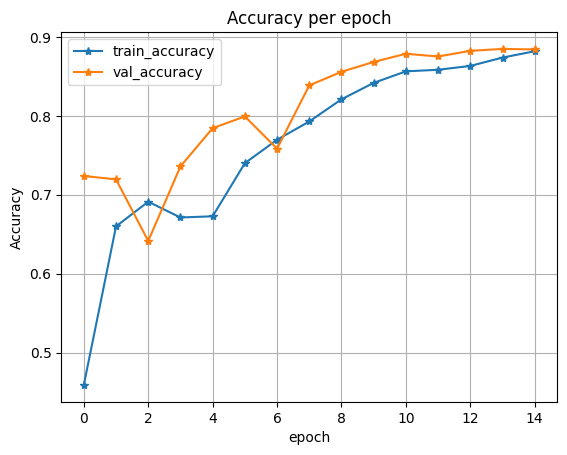

In [23]:
plot_loss(history_densenet)
plot_score(history_densenet)
plot_acc(history_densenet)

In [24]:
import pickle

In [25]:
file_name = 'fpn_mobilnet_hist.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(history_mobile, file)

file_name = 'fpn_resnet_hist.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(history_resnet, file)

file_name = 'fpn_efficient_hist.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(history_efficient, file)

file_name = 'fpn_densenet_hist.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(history_densenet, file)


# Evaluation

In [26]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## Result

In [27]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [28]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [29]:
image, mask = test_set[3]

In [30]:
pred_mask_mob, score_mob = predict_image_mask_miou(unet_mobile, image, mask)
pred_mask_res, score_res = predict_image_mask_miou(unet_resnet, image, mask)
pred_mask_eff, score_eff = predict_image_mask_miou(unet_efficient, image, mask)
pred_mask_dense, score_dense = predict_image_mask_miou(unet_densenet, image, mask)

In [31]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [32]:
mob_miou = miou_score(unet_mobile, test_set)
res_miou = miou_score(unet_resnet, test_set)
eff_miou = miou_score(unet_efficient, test_set)
dense_miou = miou_score(unet_densenet, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [33]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [34]:
mob_acc = pixel_acc(unet_mobile, test_set)
res_acc = pixel_acc(unet_resnet, test_set)
eff_acc = pixel_acc(unet_efficient, test_set)
dense_acc = pixel_acc(unet_densenet, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

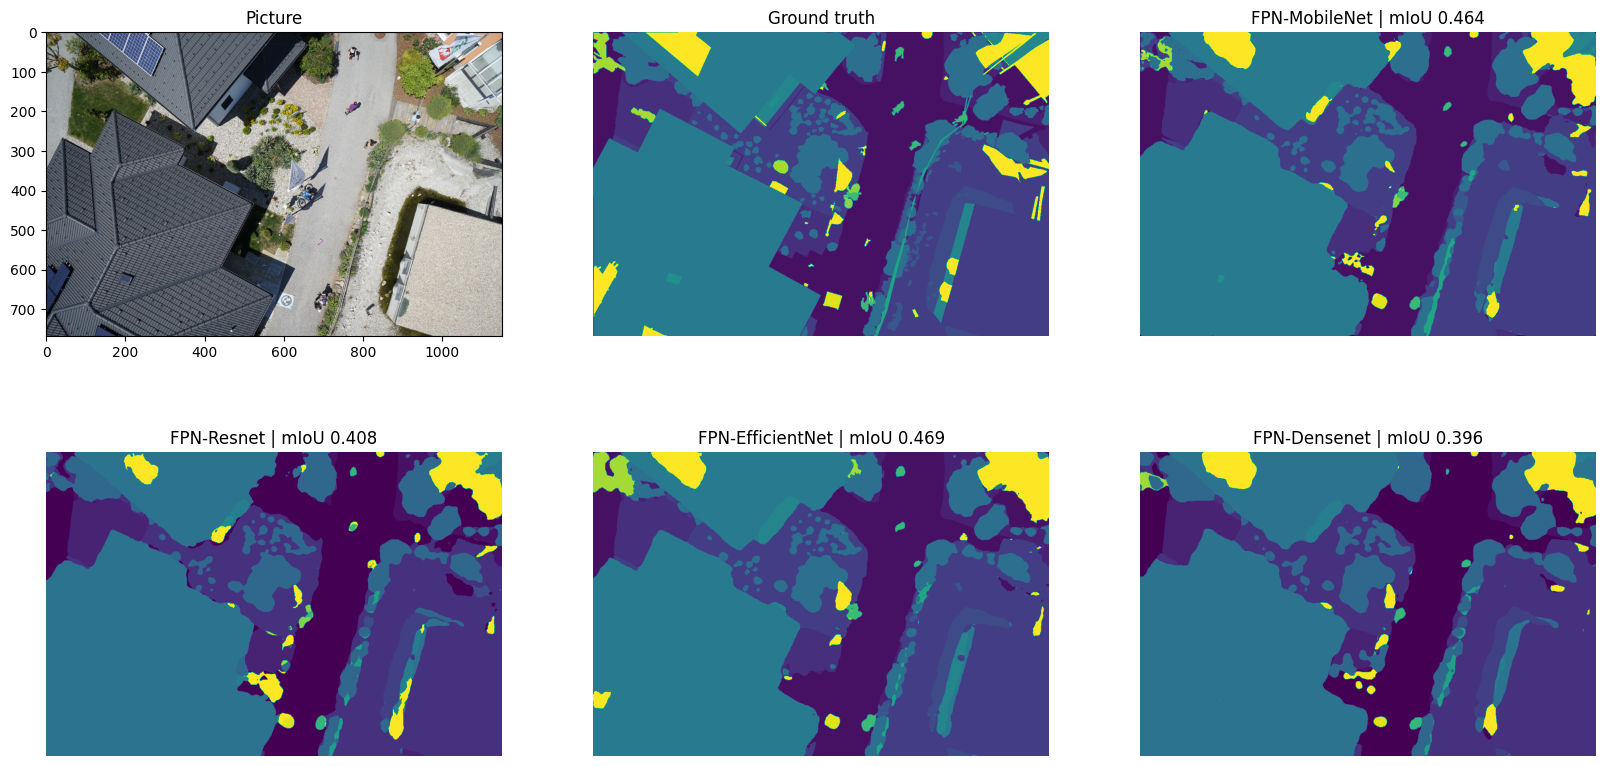

In [35]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
ax[0][0].imshow(image)
ax[0][0].set_title('Picture');

ax[0][1].imshow(mask)
ax[0][1].set_title('Ground truth')
ax[0][1].set_axis_off()

ax[0][2].imshow(pred_mask_mob)
ax[0][2].set_title('FPN-MobileNet | mIoU {:.3f}'.format(score_mob))
ax[0][2].set_axis_off()

ax[1][0].imshow(pred_mask_res)
ax[1][0].set_title('FPN-Resnet | mIoU {:.3f}'.format(score_res))
ax[1][0].set_axis_off()

ax[1][1].imshow(pred_mask_eff)
ax[1][1].set_title('FPN-EfficientNet | mIoU {:.3f}'.format(score_eff))
ax[1][1].set_axis_off()

ax[1][2].imshow(pred_mask_dense)
ax[1][2].set_title('FPN-Densenet | mIoU {:.3f}'.format(score_dense))
ax[1][2].set_axis_off()